# Introduction to Notebook 
This is a first attempt at using PyTorch to predict stock prices. In this notebook, I will be using a Linear Regression model, using the previous' day closing price, and RSI, and 50 day Exponential Moving Average (EMA) using the AlphaVantage API. 

### Rationale:
There are too many factors and techniques that investors use to predict trends in the market, and it never relies purely on technical indicators. One of the main purposes of the Notebook is not to create a model that is completely accurate, but to practice using PyTorch and basic Machine Learning ideas. However, to try to be as accurate as to not waste effort, I have chosen 3 indicators,
- 14 day RSI
- Closing price for the day prior
- 50 day Exponential Moving Average (EMA)

The main reasons I selected these 3 indicators is that the RSI and EMA help to estimate momentum of a stock. By using the EMA and RSI, the algorithm would also hopefully give more attention to recent stock data. The closing price is used to provide some sort of "foundation" for the EMA and RSI to estimate off of. 

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

ts = TimeSeries()
ti = TechIndicators()

In [2]:
# Function to get specific data for a ticker, and will reformat and remove days and their data
# from any of the arrays that do not match
# return    dates   array of dates that our ticker's data is from
#           rsi     array of the stock's rsi
#           ema50   exponential moving average that was calculated over 50 days
#           closing closing price for a day
def get_data_for_ticker(ticker):

    stock_data, _ = ts.get_intraday(symbol=ticker, interval='60min', outputsize='full')
    rsi, _ = ti.get_rsi(symbol=ticker, interval='60min', time_period=14, series_type='close')
    fty_ema, _ = ti.get_ema(symbol="AAPL", interval='60min', time_period=50, series_type='close')

    # Putting stock data into 2 arrays: 1 for dates, the other for the closing.
    stock_dates, stock_closing = ticker_helper(stock_data, "4. close", reformat=False)

    # putting rsi data into 2 arrays: 1 for dates, the other for the values
    rsi_dates, rsi_values = ticker_helper(rsi, "RSI", reformat=True)

    # Putting 50 day EMA values into 2 arrays: 1 for dates, the other for the values
    fty_ema_dates, fty_ema_values = ticker_helper(fty_ema, "EMA", reformat=True)

    similar_dates = [date for date in rsi_dates if (date in stock_dates) and (date in fty_ema_dates)]

    # Creating a list of indexes that correspond to the dates that are not within the communal date array, similar_dates
    # These arrays holds the indexes that the value arrays will need to drop
    stock_data_drop = [i for i in range(len(stock_dates)) if stock_dates[i] not in similar_dates]
    rsi_data_drop = [j for j in range(len(rsi_dates)) if rsi_dates[j] not in similar_dates]
    fty_ema_data_drop = [k for k in range(len(fty_ema_dates)) if fty_ema_dates[k] not in similar_dates]

    stock_closing = np.delete(stock_closing, stock_data_drop)
    rsi_values = np.delete(rsi_values, rsi_data_drop)
    fty_ema_values = np.delete(fty_ema_values, fty_ema_data_drop)

    return similar_dates, stock_closing, rsi_values, fty_ema_values

def ticker_helper(arr, keyVal, reformat):

    date_arr = []
    if reformat:
        date_arr = ["{}:00".format(date) for date in arr.keys()]
    else:
        date_arr = [date for date in arr.keys()]
    
    info_arr = [float(arr[date][keyVal]) for date in arr.keys()]
    date_arr.reverse()
    info_arr.reverse()
    info_arr = np.array(info_arr)

    return date_arr, info_arr


In [3]:
date, closing, rsi, ema50 = get_data_for_ticker("AAPL")

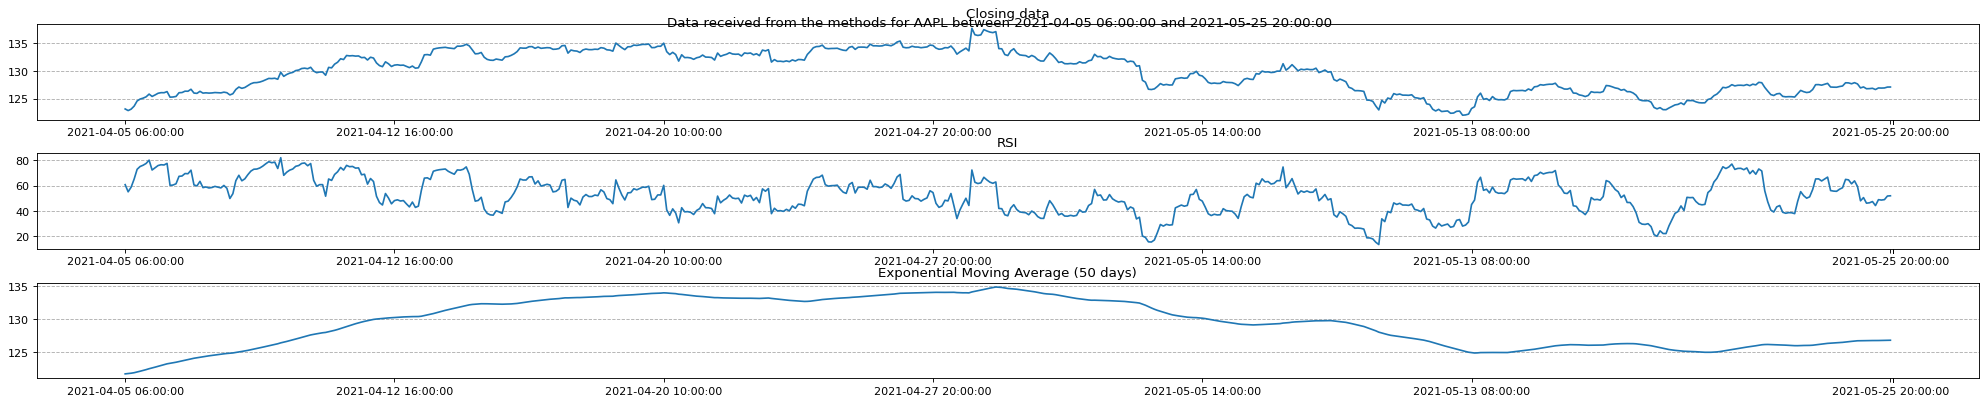

In [4]:
## Plotting the values we have gotten from the functions above
fig, (stock_graph, rsi_graph, ema_graph) = plt.subplots(3, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))
fig.tight_layout()
fig.suptitle("Data received from the methods for {} between {} and {}".format("AAPL", date[0], date[-1]))

stock_graph.plot(date, closing)
stock_graph.title.set_text("Closing data")

rsi_graph.plot(date, rsi)
rsi_graph.title.set_text("RSI")

ema_graph.plot(date, ema50)
ema_graph.title.set_text("Exponential Moving Average (50 days)")

xticks = [date[i] if ((i % 90 == 0) and (len(date) - i > 90) or i == (len(date) - 1)) else "" for i in range(len(date))]

stock_graph.set_xticks(xticks)
rsi_graph.set_xticks(xticks)
ema_graph.set_xticks(xticks)

stock_graph.grid(b=None, which='major', axis='y', linestyle='--')
rsi_graph.grid(b=None, which='major', axis='y', linestyle='--')
ema_graph.grid(b=None, which='major', axis='y', linestyle='--')

plt.show()


# Preparing/Cleaning data
This section is to prepare, clean, and reshape data.
The target (y_label) will be the closing prive for the next day.
- x_date\[i\], x_closing\[i\], x_ema\[i\] will be used to estime closing\[i+1\] <==> y_label\[i\]
- the full data array will have the keyterm all_

In [5]:
# "reset" cell - used to initialize all arrays to the prior values during the development
n_date = date
n_closing = closing
n_rsi = rsi
n_ema50 = ema50

In [6]:
# This cell will use the n_(x) variables
all_y_label = n_closing[1:]

idx_train = int(len(all_y_label) * 0.8)
idx_test = len(all_y_label) - idx_train

# splitting the data 80 (train) / 20 (test)

y_label = all_y_label[:idx_train]
y_test = all_y_label[-idx_test:]

all_date = n_date[:-1]
x_date = all_date[:idx_train]
test_date = all_date[-idx_test:]

all_closing = n_closing[:-1]
x_closing = all_closing[:idx_train]
test_closing = all_closing[-idx_test:]

all_ema50 = n_ema50[:-1]
x_ema50 = all_ema50[:idx_train]
test_ema50 = all_ema50[-idx_test:]

all_rsi = n_rsi[:-1]
x_rsi = all_rsi[:idx_train]
test_rsi = all_rsi[-idx_test:]


In [7]:
tab = "|"+" "*3
print("Checking the lengths of the arrays")
print("all y: ", len(all_y_label), tab, "y label: ", len(y_label), tab, "y test: ", len(y_test))
print("all date: ", len(all_date), tab, "x_date: ", len(x_date), tab, "test_date: ", len(test_date))
print("all closing: ", len(all_closing), tab, "x_closing: ", len(x_closing), tab, "test_closing: ", len(test_closing))
print("all ema50: ", len(all_ema50), tab, "x_ema50: ", len(x_ema50), tab, "test_ema50: ", len(test_ema50))
print("all rsi: ", len(all_rsi), tab, "x_rsi: ", len(x_rsi), tab, "test_rsi: ", len(test_rsi))

Checking the lengths of the arrays
all y:  590 |    y label:  472 |    y test:  118
all date:  590 |    x_date:  472 |    test_date:  118
all closing:  590 |    x_closing:  472 |    test_closing:  118
all ema50:  590 |    x_ema50:  472 |    test_ema50:  118
all rsi:  590 |    x_rsi:  472 |    test_rsi:  118


In [8]:
# Converting into PyTorch tensors
y_label = torch.tensor(y_label)
y_label = torch.reshape(y_label, (len(y_label), 1))
x_closing = torch.tensor(x_closing)
x_ema50 = torch.tensor(x_ema50)
x_rsi = torch.tensor(x_rsi)

# stacking input tensors to form 1 matrix of (len(x_closing) x 3) shape
train_input = torch.stack((x_closing, x_ema50, x_rsi), 1)

# Starting the build the neural network (Linear Regression)
The optimizer, loss function and model will be imported from pytorch
- Loss function: Mean squared error
- Optimizer: Stochastic Gradient Descent 

In [13]:
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

def train(epochs, model, loss_fnc, optimizer, train_data):
    for e in range(epochs):
        for x, y in train_data:
            pred = model(x.float())
            loss = loss_fnc(pred, y.float())
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

        if (e+1) % 10 == 0:
            print("Epoch [{} / {}], Loss: {:.4f}".format(e+1, epochs, loss.item()))

train_ds = TensorDataset(train_input, y_label)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

model = nn.Linear(3,1)
loss_fn = F.mse_loss
opt = torch.optim.SGD(model.parameters(), lr = 1e-5)

# Pre-trained model result

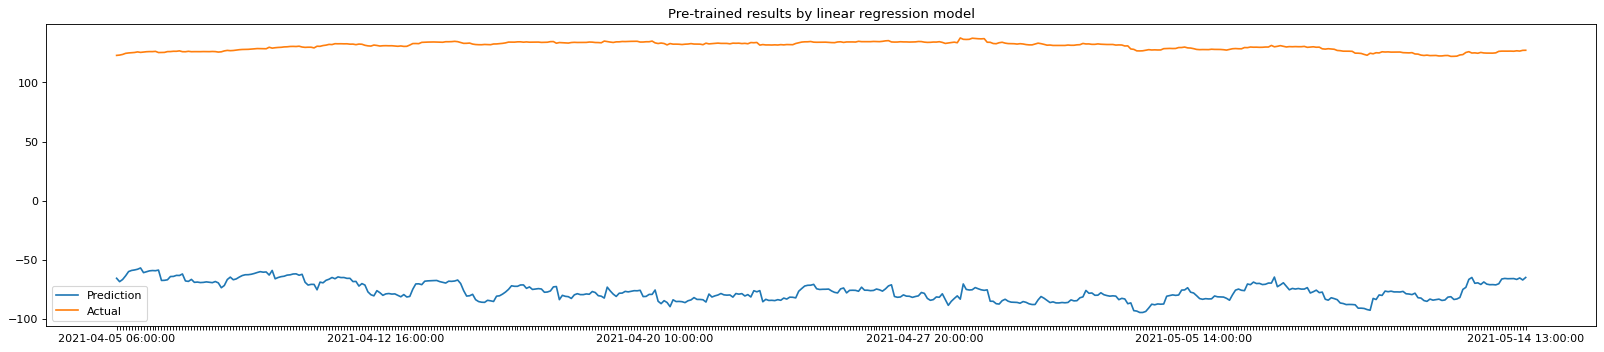

In [14]:
pre_train_result = model(train_input.float())

## plot the graphs
fig= plt.figure(2, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(x_date, pre_train_result.detach().numpy())
plt.plot(x_date, y_label)

plt.legend(['Prediction', "Actual"])

xticks = [x_date[i] if ((i%90 == 0 and (len(x_date) - i) > 90) or i == (len(x_date) - 1)) else None for i in range(len(x_date))]
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='horizontal')

plt.title('Pre-trained results by linear regression model')
plt.show()

# Training the model

In [15]:
train(80, model, loss_fn, opt, train_dl)

Epoch [10 / 80], Loss: 6.9346
Epoch [20 / 80], Loss: 0.2540
Epoch [30 / 80], Loss: 1.3562
Epoch [40 / 80], Loss: 0.0545
Epoch [50 / 80], Loss: 0.1256
Epoch [60 / 80], Loss: 0.7252
Epoch [70 / 80], Loss: 0.2512
Epoch [80 / 80], Loss: 0.7462


# Plotting the post trained result

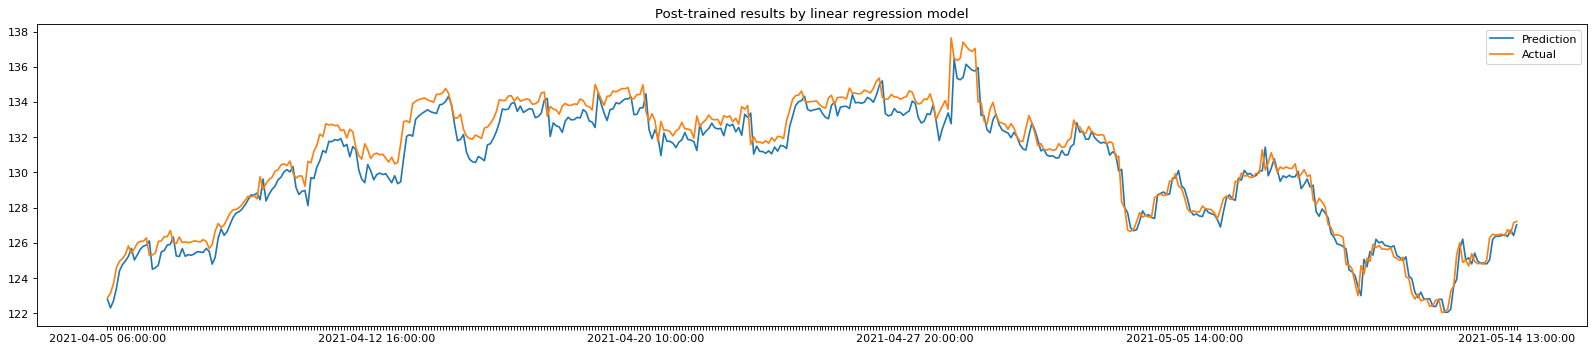

In [16]:
new_prediction = model(train_input.float())

## plot the graphs
fig= plt.figure(2, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(x_date, new_prediction.detach().numpy())
plt.plot(x_date, y_label)

plt.legend(['Prediction', "Actual"])

xticks_post = [x_date[i] if ((i%90 == 0 and (len(x_date) - i) > 90) or i == (len(x_date) - 1)) else None for i in range(len(x_date))]
x_post = np.arange(0,len(xticks_post))
plt.xticks(x_post, xticks_post, rotation='horizontal')

plt.title('Post-trained results by linear regression model')
plt.show()

# Testing against the last 20% of the historical data

In [17]:
test_closing = torch.tensor(test_closing)
test_rsi = torch.tensor(test_rsi)
test_ema50 = torch.tensor(test_ema50)

test_input = torch.stack((test_closing, test_ema50, test_rsi), 1)

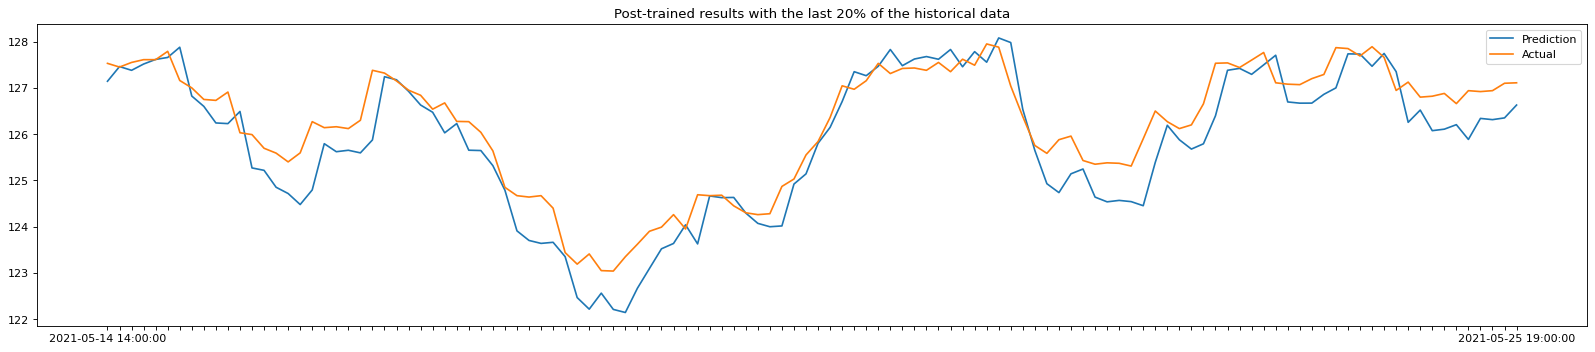

In [18]:
test_prediction = model(test_input.float())

## plot the graph
fig = plt.figure(2, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(test_date, test_prediction.detach().numpy())
plt.plot(test_date, y_test)

plt.legend(['Prediction', "Actual"])

xticks_20 = [test_date[i] if ((i%90 == 0 and (len(test_date) - i) > 90) or i == (len(test_date) - 1)) else None for i in range(len(test_date))]
x_20 = np.arange(0,len(xticks_20))
plt.xticks(x_20, xticks_20, rotation='horizontal')

plt.title('Post-trained results with the last 20% of the historical data')
plt.show()

# Testing against another ticker (MSFT)

In [19]:
msft_date, msft_closing, msft_rsi, msft_ema50 = get_data_for_ticker("MSFT")

In [20]:
msft_closing = torch.tensor(msft_closing)
msft_rsi = torch.tensor(msft_rsi)
msft_ema50 = torch.tensor(msft_ema50)

In [21]:
msft_input = torch.stack((msft_closing, msft_ema50, msft_rsi), 1)

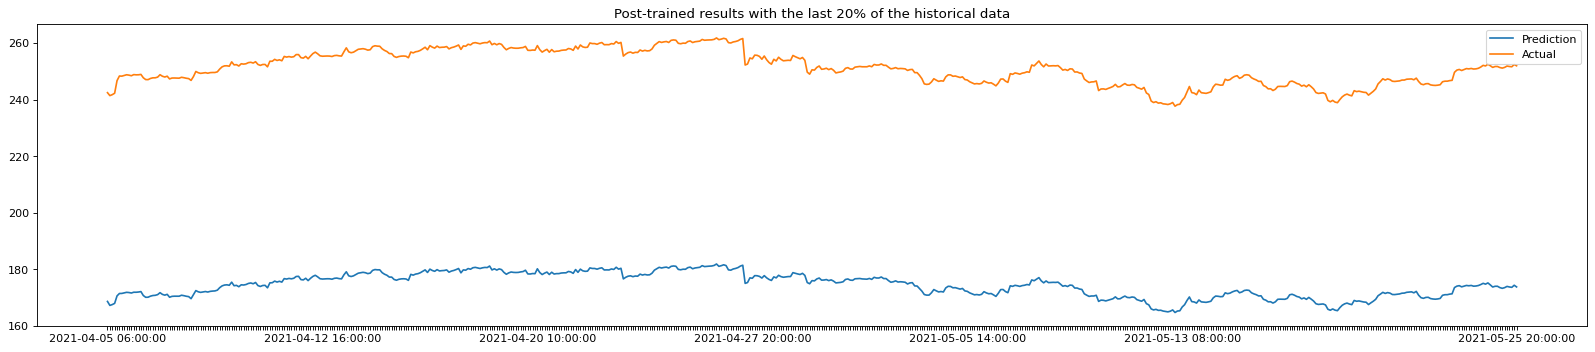

In [22]:
msft_prediction = model(msft_input.float())

# Plotting the results

fig = plt.figure(2, figsize=(25,5), dpi = 80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(msft_date, msft_prediction.detach().numpy())
plt.plot(msft_date, msft_closing)

plt.legend(['Prediction', "Actual"])

xticks_20 = [msft_date[i] if ((i%90 == 0 and (len(msft_date) - i) > 90) or i == (len(msft_date) - 1)) else None for i in range(len(msft_date))]
x_20 = np.arange(0,len(xticks_20))
plt.xticks(x_20, xticks_20, rotation='horizontal')

plt.title('Prediction for the Microsoft stock')
plt.show()

In [25]:
print(model.weight)

Parameter containing:
tensor([[0.3710, 0.5939, 0.0741]], requires_grad=True)


# Testing against another ticker (FTNT)

In [26]:
ftnt_date, ftnt_closing, ftnt_rsi, ftnt_ema = get_data_for_ticker('FTNT')

In [27]:
ftnt_closing = torch.tensor(ftnt_closing[1:])
ftnt_rsi = torch.tensor(ftnt_rsi[1:])
ftnt_ema = torch.tensor(ftnt_ema[1:])

ftnt_input = torch.stack((ftnt_closing, ftnt_ema, ftnt_rsi), 1)

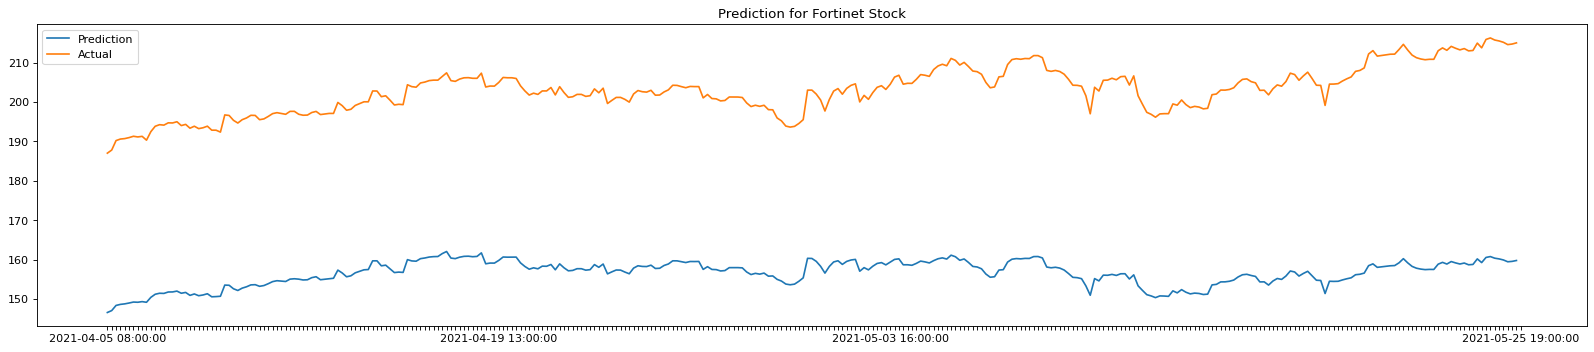

In [28]:
ftnt_prediction = model(ftnt_input.float())

# Plotting the results

fig = plt.figure(2, figsize=(25,5), dpi = 80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(ftnt_date[1:], ftnt_prediction.detach().numpy())
plt.plot(ftnt_date[1:], ftnt_closing)

plt.legend(['Prediction', "Actual"])

xticks_ftnt = [ftnt_date[i] if ((i%90 == 0 and (len(ftnt_date) - i) > 90) or i == (len(ftnt_date) - 1)) else None for i in range(len(ftnt_date))]
x_ftnt = np.arange(0,len(xticks_ftnt))
plt.xticks(x_ftnt, xticks_ftnt, rotation='horizontal')

plt.title('Prediction for Fortinet Stock')
plt.show()